###  Import Libraries

In [2]:
#importing libraries
import tensorflow as tf
import json
import os # to get the images
import time 
import uuid #allows to create uniform unique id
import cv2  #image processing
import numpy as np #numerical python
import matplotlib.pyplot as plt #plotting
# import albumentations as alb #image augmentation
from tensorflow.keras.models import Model #to create model
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D,Dense #layers of the model
from tensorflow.keras.applications import VGG16 #pretrained model architecture



### Creating Dataset

In [3]:
IMAGE_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
#istablishing connection with our video camera
cap = cv2.VideoCapture(0)

for img_num in range(number_images):
    print(f"Collecting images {img_num}")
    ret,frame = cap.read()
    imagename = os.path.join(IMAGE_PATH,f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imagename,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5) 
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
# move matching labels to the same folder

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename = file.split('.')[0]+'.json'

        existing_file = os.path.join('data','labels',filename)
        if os.path.exists(existing_file):
            new_file = os.path.join('data',folder,'labels',filename)
            os.replace(existing_file,new_file)


In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params = alb.BboxParams(format='albumentations',
                                                    label_fields=['class_labels']))

In [ ]:
# build and run augmentation pipeline

for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))
        
        coords = [0,0,0.00001,0.00001]
        
        label_path = os.path.join('data',partition,'labels',f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label = json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0] 
            coords[1] = label['shapes'][0]['points'][0][1] 
            coords[2] = label['shapes'][0]['points'][1][0] 
            coords[3] = label['shapes'][0]['points'][1][1] 

            coords = list(np.divide(coords,[640,480,640,480])) #normalizing
    
        try:
            for x in range(60):
                augmented = augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f"{image.split('.')[0]}.{x}.jpg"),augmented['image'])
                
                annotation = {}
                annotation['image']=image
                
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox']=augmented['bboxes'][0]
                        annotation['class']=1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class']=0
                    
                with open(os.path.join('aug_data',partition,'labels',f"{image.split('.')[0]}.{x}.json"),'w') as f:
                    json.dump(annotation,f)
                    
        except Exception as e:
            print(e)

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def preprocess(image):
    # Ensure the image has 3 channels and a defined shape
    image = tf.image.resize(image, [120, 120])
    image = tf.ensure_shape(image, [120, 120, 3])  # Assuming RGB images
    
    return image


def get_images(path):
    images = tf.data.Dataset.list_files(path,shuffle=False)
    images = images.map(load_image)
    images = images.map(preprocess) #so that we can make more efficient neural network
    images = images.map(lambda x: x/255.0) #normalizing the images
    return images

In [7]:
train_images = get_images('aug_data/train/images/*.jpg')
test_images = get_images('aug_data/test/images/*.jpg')
val_images = get_images('aug_data/val/images/*.jpg')

In [8]:
def load_labels(path):
    with open(path.numpy(),'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']],label['bbox']

def get_labels(path):
    labels = tf.data.Dataset.list_files(path,shuffle=False)
    labels = labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))
    return labels

In [9]:
train_labels = get_labels('aug_data/train/labels/*.json')
test_labels = get_labels('aug_data/test/labels/*.json')
val_labels = get_labels('aug_data/val/labels/*.json')

In [10]:
def dataset(images,labels):
    data = tf.data.Dataset.zip(images,labels) #combining images and labels using zip 
    data = data.shuffle(5000) #should be shuffle bigger than the size of the image
    #data = data.map(preprocess)
    data = data.batch(8) #in one batch there is 8 images and 8 labels
    data = data.prefetch(4) 
    return data

In [11]:
train = dataset(train_images,train_labels)
test = dataset(test_images,test_labels)
val = dataset(val_images,val_labels)


### Vizualizing some sample images

In [10]:
# view the image and annotations
data_sample = train.as_numpy_iterator()
res = data_sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


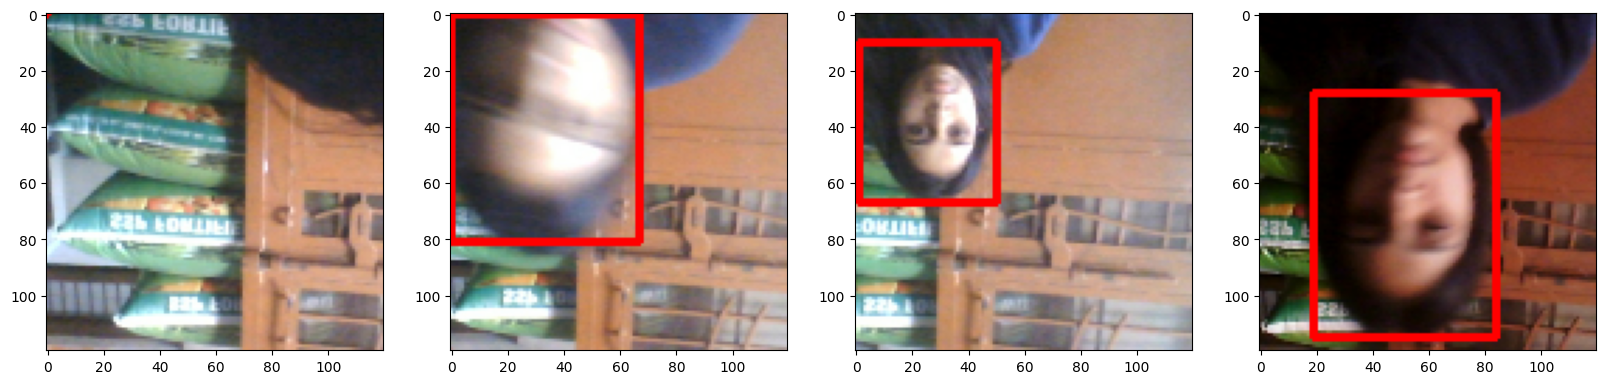

In [11]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    # Convert sample_image to cv::UMat
    sample_image_um = cv2.UMat(sample_image)

    # Now draw the rectangle using sample_image_um
    cv2.rectangle(sample_image_um,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    # If you need to convert back to NumPy array for display (optional)
    sample_image = cv2.UMat.get(sample_image_um)
    ax[idx].imshow(sample_image)


### Building the Deep Learning Model

In [14]:
vgg = VGG16(include_top=False) # false because we don't need final layers of the model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step


In [15]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
def build_model():
    '''
    1. First I am creating input layer with shape of 120,120 with 3 channels
    2. Then, passing the input layer to the vgg16 architecture where we didn't include final layers
    3. After this I am going to pass the output of vgg16 to GlobalMaxPooling layer  where i first get the classification (face or not face) ,
        then going to predict the coordinate of the box to check in the image where is the actual face present.
    '''
    input_layer = Input(shape=(120,120,3)) 
    
    vgg = VGG16(include_top = False)(input_layer)
    
    # 1st prediction head is for classification
    f1 = GlobalMaxPooling2D()(vgg) # to classify face or not
    class1 = Dense(2048,activation='relu')(f1)
    class2 = Dense(1,activation='sigmoid')(class1)
    
    # 2nd is for prediction the coordinate points (bounding box)
    f2 = GlobalMaxPooling2D()(vgg) # to predict coordinate
    regress1 = Dense(2048,activation='relu')(f2)
    regress2 = Dense(4,activation='sigmoid')(regress1)
    
    model = Model(inputs=input_layer,outputs=[class2,regress2])
    return model


In [3]:
facetracker = build_model()

In [18]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
X,y = train.as_numpy_iterator().next()

In [20]:
classes,coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [21]:
classes

array([[0.4802955 ],
       [0.5312506 ],
       [0.39484712],
       [0.50920284],
       [0.45765907],
       [0.4374497 ],
       [0.47463784],
       [0.4636564 ]], dtype=float32)

In [23]:
coords

array([[0.52370715, 0.5245695 , 0.5680817 , 0.6280297 ],
       [0.46929514, 0.5016782 , 0.5757537 , 0.63761294],
       [0.4223515 , 0.664189  , 0.57823265, 0.6625142 ],
       [0.45990878, 0.60545975, 0.54584706, 0.64338183],
       [0.46856463, 0.5400277 , 0.5629605 , 0.61516607],
       [0.50118226, 0.53372884, 0.5405371 , 0.6011139 ],
       [0.57091457, 0.63259894, 0.42996556, 0.6759064 ],
       [0.57997346, 0.5220579 , 0.55618787, 0.6832588 ]], dtype=float32)

In [12]:
batches_per_epoch = 615
lr_decay = (1./0.75 -1)/batches_per_epoch
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [13]:
def localization_loss(ytrue,ypred):
    
    delta_coords = tf.reduce_sum(tf.square(ytrue[:, :2] - ypred[:, :2]))
    # here delta_coord is the sum of the difference between true and pred value of coordinate
    
    htrue = ytrue[:,3]-ytrue[:,1]
    wtrue = ytrue[:,2]-ytrue[:,0]
    
    hpred = ypred[:,3]-ypred[:,1]
    wpred = ypred[:,2]-ypred[:,0]
    
    delta_size = tf.reduce_sum(tf.square(wtrue - wpred) + tf.square(htrue-hpred))
    # same with delta_size
    return delta_coords + delta_size
    

In [14]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressionloss = localization_loss

### Training the Model

In [15]:
class FaceTracker(Model):
    def __init__(self,facetracker,**kwargs):
        super().__init__(**kwargs)
        if facetracker is None:
            facetracker = build_model()
        self.model = facetracker
        


    def compile(self, opt=None, classloss=None, localizationloss=None, **kwargs):
        super(FaceTracker, self).compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

        
    @tf.function    
    def train_step(self,batch,**kwargs):
        
        X,y = batch
        # Print shapes for debugging
        #print(f'X shape: {X.shape}')
        #print(y)
        
        yc = tf.ensure_shape(y[0], [None, 1])  # Example for class labels
        ycoord = tf.ensure_shape(y[1], [None, 4])   # Example for coordinates

        #print(yc,ycoord)
        with tf.GradientTape() as tape:
            classes,coords = self.model(X,training=True)


            # Print shapes of model outputs
            #print(f'classes shape: {classes.shape}')
            #print(f'coords shape: {coords.shape}')
            batch_classloss = self.closs(yc,classes)
            batch_localizationloss = self.lloss(tf.cast(ycoord,tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss,self.model.trainable_variables)
            
        self.opt.apply_gradients(zip(grad,self.model.trainable_variables))
        
        return {"total_loss":total_loss,"class_loss":batch_classloss,'regress_loss':batch_localizationloss}
    
    @tf.function
    def test_step(self,batch,**kwargs):
        X,y = batch
        yc = tf.ensure_shape(y[0], [None, 1])  # Example for class labels
        ycoord = tf.ensure_shape(y[1], [None, 4])   # Example for coordinates
        
        classes,coords = self.model(X,training=False)
        
        batch_classloss = self.closs(yc,classes)
        batch_localizationloss = self.lloss(tf.cast(ycoord,tf.float32), coords)
        
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss":total_loss,"class_loss":batch_classloss,'regress_loss':batch_localizationloss}
    
    def call(self,X, **kwargs):
        return self.model(X,**kwargs)
    
    
    def get_config(self):
        config = super(FaceTracker, self).get_config()
        config.update({
            'facetracker': self.model,
            'opt': self.opt,
            'classloss': self.closs,
            'localizationloss': self.lloss
        })
        return config

    @classmethod
    def from_config(cls, config):
        facetracker = config.pop('facetracker')
        opt = config.pop('opt')
        classloss = config.pop('classloss')
        localizationloss = config.pop('localizationloss')
        return cls(facetracker=facetracker, opt=opt, classloss=classloss, localizationloss=localizationloss, **config)

    

In [37]:
model = FaceTracker(facetracker)

In [50]:
model.compile(optimizer,classloss,regressionloss)

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history = model.fit(train,epochs=40, validation_data = val,callbacks=[tensorboard_callback])

In [ ]:
model.save('facedetector.h5')

In [16]:
# Load the model with custom objects
model = tf.keras.models.load_model(
    'facedetector.h5',
    custom_objects={
        'FaceTracker': lambda **kwargs: FaceTracker(facetracker=facetracker, **kwargs),
        'localization_loss': localization_loss,
        'facetracker':build_model
    }
)



In [17]:
model.compile(
    optimizer=optimizer,
    loss={
        'class_loss': classloss,
        'localization_loss': regressionloss
    }
)

In [18]:
test_data = test.as_numpy_iterator()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


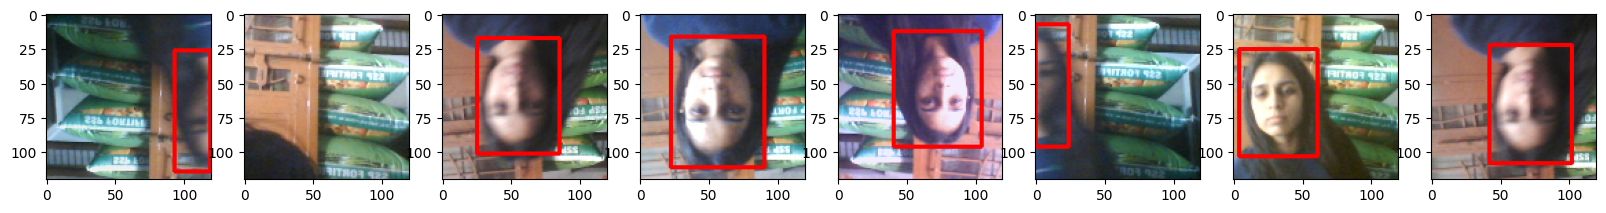

In [19]:
test_sample = test_data.next()

ypred = model.predict(test_sample[0])
fig,ax = plt.subplots(ncols=8,figsize=(20,20))

for i in range(8):
    sample_image = test_sample[0][i]
    sample_coords = ypred[1][i]
    
    if ypred[0][i]>0.5:
        # Convert sample_image to cv::UMat
        sample_image_um = cv2.UMat(sample_image)

        # Now draw the rectangle using sample_image_um
        cv2.rectangle(sample_image_um,
                          tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                          (255, 0, 0), 2)

        # If you need to convert back to NumPy array for display (optional)
        sample_image = cv2.UMat.get(sample_image_um)
    
    ax[i].imshow(sample_image)


       

In [76]:
ypred

[array([[0.9999997 ],
        [0.00334058],
        [1.        ],
        [0.9999997 ],
        [0.99999994],
        [1.        ],
        [0.9999996 ],
        [0.9999997 ]], dtype=float32),
 array([[0.37641445, 0.31413895, 0.7532097 , 0.83533305],
        [0.01804205, 0.00601389, 0.02159785, 0.02689589],
        [0.23099688, 0.19766334, 0.84197164, 0.97388023],
        [0.24387603, 0.11818717, 0.72492075, 0.7620805 ],
        [0.01505135, 0.15456788, 0.49100095, 0.84669125],
        [0.38190335, 0.03562595, 0.95898336, 0.851491  ],
        [0.37708572, 0.194238  , 0.8855212 , 0.8881561 ],
        [0.23938455, 0.14862975, 0.7252357 , 0.8011514 ]], dtype=float32)]

In [2]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')


In [26]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _,frame = cap.read()
    frame = frame[0:450,0:450,:]

    rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb,(120,120))
    
    ypred = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords =ypred[1][0]
    
    if ypred[0]>0.7:
        cv2.rectangle(frame,
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                  (0, 255, 0), 2)
        # cv2.rectangle(frame,
        #              tuple(np.add(np.multiply(sample_coords[:2],[,450]).astype(int),
        #                           [0,-30])),
        #              tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),
        #                           [80,0])),
        #                          (255,0,0),-1)
        cv2.putText(frame,'face',tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),
                                  [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    cv2.imshow('FaceDetect',frame)     
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━